<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_3_1_3_momentum_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Momentum

In [ ]:
import torch
from matplotlib import pyplot as plt

def eggholder(w0,w1):
  a = -(w1 + 47) * torch.sin(torch.sqrt(torch.abs(w1 + w0/2 + 47)))
  b = -w0 * torch.sin(torch.sqrt(torch.abs(w0 - (w1 + 47))))
  return a+b
def draw_descent():
  plt.contourf(grid0, grid1, grid_cost, cmap="Greys");
  plt.scatter(history[0,0], history[0,1], marker="o", color="r")
  plt.scatter(history[-1,0], history[-1,1], marker="x", s=100, color="r")
  plt.plot(history[:,0], history[:,1], linestyle=':', marker="x", color="r")
  plt.xlabel("$w_0$");
  plt.ylabel("$w_1$");

In [ ]:
range0, range1 = torch.linspace(0, 512, 1000), torch.linspace(0, 512, 1000)
grid0,grid1    = torch.meshgrid(range0, range1)
grid_cost      = torch.zeros(grid0.size())
grid_cost      = eggholder(grid0, grid1)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
def SGD_egg(alpha=1, start=[250., 350.], beta=0, decay=1):
#optimizer = torch.optim.SGD(model, lr=alpha,momentum=beta)

  torch.manual_seed(0)
  w          = torch.tensor(start, requires_grad=True)
  velocity   = torch.tensor([0.,0.], requires_grad=False)
  iterations = 50
  history    = torch.zeros(1+iterations,2)
  history[0,:] = w.detach()
  for idx in range(iterations):
    cost = eggholder(w[0], w[1])
    cost.backward()
    with torch.no_grad():
      velocity = beta * velocity + (w.grad * torch.normal(1, 15, size=w.size()))
      alpha    = alpha * decay
      w       -= alpha * velocity
    w.grad.zero_()
    history[1+idx,:] = w.detach()
  return history

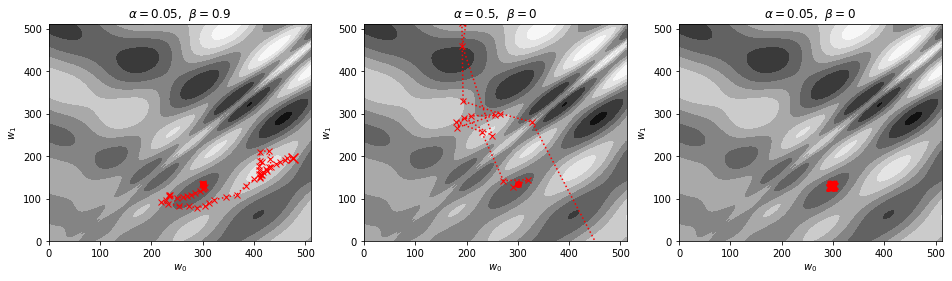

In [ ]:
b=0.9
a=0.5
d=1
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
history = SGD_egg(alpha=a*(1-b), beta=b, start=[300., 135.], decay=d)
draw_descent()
#plt.xlim((0,512))
#plt.ylim((0,512))
plt.title(r"$\alpha=0.05$,  $\beta=0.9$");

plt.subplot(1,3,2)
history = SGD_egg(alpha=a, beta=0, start=[300., 135.], decay=d)
draw_descent()
plt.xlim((0,512))
plt.ylim((0,512))
plt.title(r"$\alpha=0.5$,  $\beta=0$");

plt.subplot(1,3,3)
history = SGD_egg(alpha=a*(1-b), beta=0, start=[300., 135.], decay=d)
draw_descent()
#plt.xlim((0,512))
#plt.ylim((0,512))
plt.title(r"$\alpha=0.05$,  $\beta=0$");

#Adam

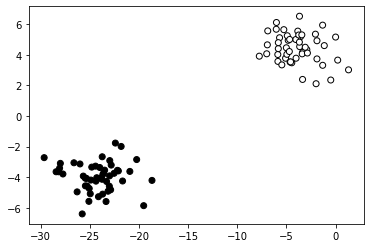

In [ ]:
import sklearn.datasets as skds
X, Y = skds.make_blobs(n_samples=100, n_features=2,
                       centers=2, random_state=1)
X, Y = torch.tensor(X), torch.tensor(Y)

X[:,0] = 2.5 * X[:,0] #this is new
plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

z         = lambda w0,w1,b,x0,x1: w0*x0 + w1*x1 + b
y         = lambda z: 1/(1 + torch.exp(-z))
clip_prob = lambda y: torch.max(eps,torch.min(1-eps, y)) 
model     = lambda w0,w1,b,x0,x1: clip_prob(y(z(w0, w1, b, x0, x1)))
eps       = torch.tensor(10**-6)
H         = lambda y,yt: -(yt*torch.log(y) + (1-yt)*torch.log(1-y))
C         = lambda cost_per_point: cost_per_point.mean()
cost_by_w0w1= lambda w0,w1: C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

def draw_prob_contours():
  x0, x1 = torch.linspace(-120, 1, 100), torch.linspace(-7, 7, 100)
  grid0, grid1 = torch.meshgrid(x0,x1)
  fig = plt.contour(grid0,grid1,model(w0, w1, b, grid0, grid1), cmap="Greys")
  fig.clabel(inline=True, fontsize=10)
  plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

In [ ]:
b=5
range0, range1 = torch.linspace(-7, 7, 100), torch.linspace(-7, 7, 100)
grid0, grid1   = torch.meshgrid(range0, range1)
grid_cost      = torch.zeros(grid0.size())
for index0 in range(len(range0)):
  for index1 in range(len(range1)):
    w0 = grid0[index0,index1]
    w1 = grid1[index0,index1]
    grid_cost[index0,index1] = C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

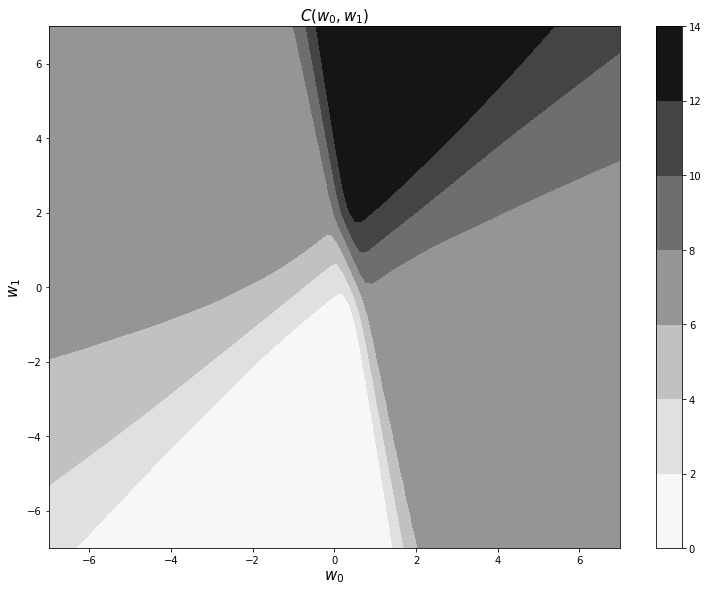

In [ ]:
plt.figure(figsize=[12.8, 9.6])
plt.contourf(grid0, grid1, grid_cost, cmap="Greys");
plt.xlabel("$w_0$", size=15)
plt.ylabel("$w_1$", size=15)
plt.title("$C(w_0,w_1)$", size=15)
plt.colorbar();

In [ ]:
def generate_descent(alpha=0.05, beta=0, start=[0, 3.5], adam_flag=False):
  w   = torch.tensor(start,requires_grad=True)
  net = [w]
  if adam_flag:
    optimizer = torch.optim.Adam(net, lr=alpha)
  else:  
    optimizer  = torch.optim.SGD(net, lr=alpha, momentum=beta)
  iterations   = 25
  history      = torch.zeros(1+iterations,2)
  history[0,:] = w.detach()
  batch_idx    = 1
  batch_size   = 2
  for idx in range(iterations):
    X_batch = X[batch_idx:(batch_idx+batch_size),:]
    Y_batch = Y[batch_idx:(batch_idx+batch_size)]
    batch_idx = batch_idx + batch_size
    optimizer.zero_grad()
    cost=C(H(model(
        w[0], w[1], b,X_batch[:, 0], X_batch[:, 1]), Y_batch))
    cost.backward()
    optimizer.step()
    history[1+idx,:] = w.detach()
  return history

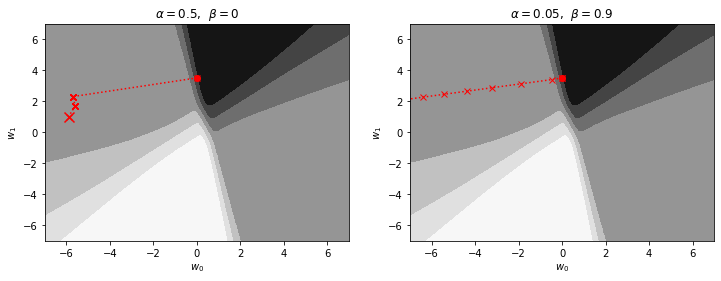

In [ ]:
a=0.5
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
history = generate_descent(alpha=a)
draw_descent()

plt.title(r"$\alpha=0.5$,  $\beta=0$");

b=0.9
plt.subplot(1,2,2)
history = generate_descent(alpha=a*(1-b),beta=b)
draw_descent()
plt.xlim((-7,7))
plt.ylim((-7,7))
plt.title(r"$\alpha=0.05$,  $\beta=0.9$");

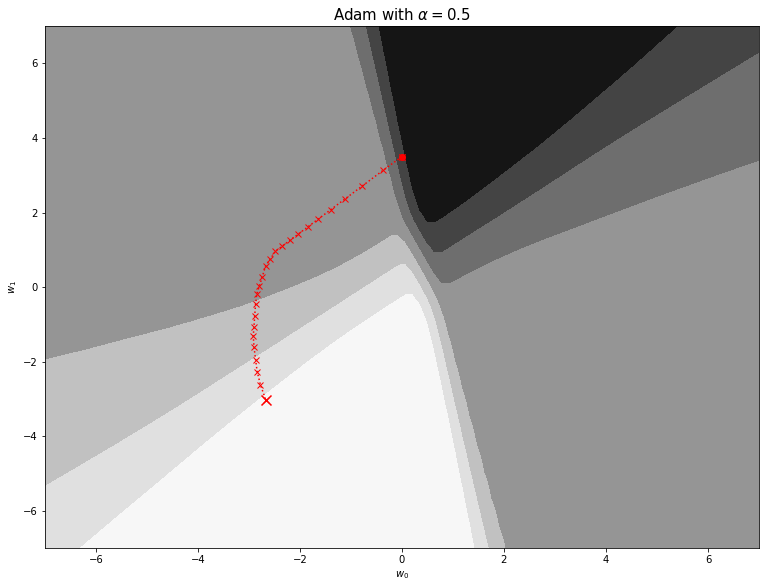

In [ ]:
plt.figure(figsize=[12.8, 9.6])
history = generate_descent(alpha=a, adam_flag=True)
draw_descent()
plt.title(r"Adam with $\alpha=0.5$",size=15);